In [5]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib import colormaps 
import seaborn as sns
#https://github.com/vinsburg/alluvial_diagram
import alluvial
from collections import Counter
import copy

In [6]:
client = bigquery.Client(project='subugoe-wag-closed')

In [30]:
s2ag_papers = 'subugoe-wag-closed.S2AG.papers'
upw_snapshot = 'subugoe-collaborative.upw_instant.snapshot'

In [8]:
sns.set_style('whitegrid')
plt.rc('font', family='Arial')
plt.rc('font', size=9) 
plt.rc('axes', titlesize=9) 
plt.rc('axes', labelsize=9) 
plt.rc('xtick', labelsize=9) 
plt.rc('ytick', labelsize=9) 
plt.rc('legend', fontsize=9)

## Abdeckung von DOIs

In [9]:
df_doi = client.query(f"""
                       SELECT COUNT(DISTINCT(externalids.DOI)) AS number_of_dois, 
                              COUNT(DISTINCT(corpusid)) AS number_of_publications, 
                              EXTRACT (YEAR FROM publicationdate) AS year
                       FROM {s2ag_papers} 
                       GROUP BY year
                       ORDER BY year DESC
                       """).to_dataframe()

In [10]:
df_doi['number_of_dois'].sum()

114924476

In [11]:
df_doi['number_of_publications'].sum()

210579294

In [12]:
df_doi_2000 = df_doi[(df_doi.year >= 2000) & (df_doi.year < 2023)]

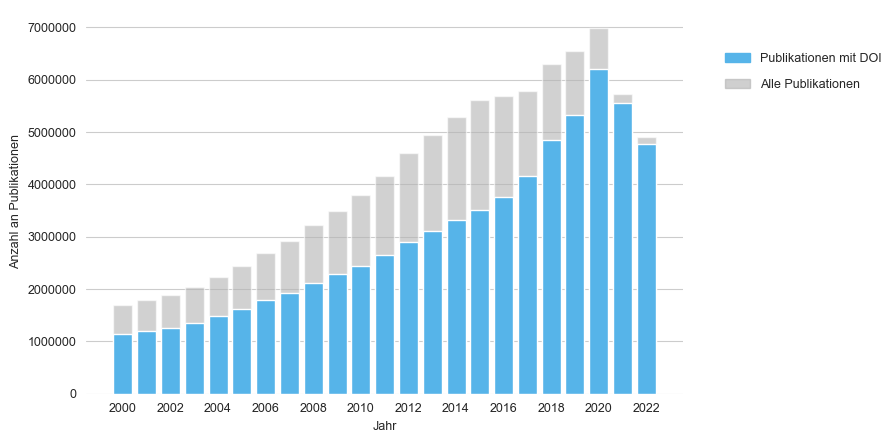

In [13]:
fig, ax = plt.subplots(figsize=(7,4.5))
plt.box(False)

sns.barplot(data=df_doi_2000, 
            x='year', 
            y='number_of_publications', 
            alpha=0.6,
            color='#b3b3b3a0',
            saturation=1,
            ci=None)

sns.barplot(data=df_doi_2000, 
            x='year', 
            y='number_of_dois', 
            alpha=1,
            color='#56B4E9',
            saturation=1,
            ci=None)

plt.locator_params(nbins=12, axis='x')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))

ax.set(xlabel='Jahr', ylabel='Anzahl an Publikationen')

doi_patch = mpatches.Patch(color='#56B4E9', label='Publikationen mit DOI')
not_doi_patch = mpatches.Patch(color='#b3b3b3a0', label='Alle Publikationen')

lgd = fig.legend(handles=[doi_patch, not_doi_patch], frameon=False,
                 bbox_to_anchor=(1.28, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()
fig.savefig('media/doi.png', format='png', bbox_inches='tight', dpi=500)

## Abdeckung von Publikationstypen

In [14]:
df_types_single = client.query(f"""
                                SELECT type, MIN(year) AS span_min, MAX(year) AS span_max, 
                                       COUNT(DISTINCT(corpusid)) AS number_of_publications
                                FROM (
                                     SELECT DISTINCT type, corpusid, EXTRACT (YEAR FROM publicationdate) AS year
                                     FROM {s2ag_papers}, UNNEST(publicationtypes) as type 
                                     )
                                GROUP BY type
                                """).to_dataframe()

In [15]:
df_types_single

,type,span_min,span_max,number_of_publications
0,JournalArticle,1708,2023,39583455
1,Study,1893,2023,2341438
2,Review,1708,2023,14607813
3,LettersAndComments,1817,2023,1539429
4,CaseReport,1838,2023,2175516
5,Conference,1754,2023,3845648
6,Editorial,1812,2023,656743
7,ClinicalTrial,1901,2023,582157
8,Book,1856,2023,274375
9,MetaAnalysis,1966,2023,103671


In [16]:
df_types_agg = client.query(f"""
                             SELECT ARRAY_TO_STRING(publicationtypes, ",") AS types, 
                                    COUNT(DISTINCT(corpusid)) AS number_of_publications
                             FROM {s2ag_papers}
                             GROUP BY types
                             ORDER BY number_of_publications DESC
                             """).to_dataframe()

In [17]:
df_types_agg

,types,number_of_publications
0,,157488277
1,JournalArticle,28452480
2,Review,8790961
3,"Review,JournalArticle",2645627
4,Conference,2254022
...,...,...
615,"Editorial,LettersAndComments,JournalArticle,Cl...",1
616,"LettersAndComments,CaseReport,JournalArticle,E...",1
617,"LettersAndComments,MetaAnalysis,Editorial,Review",1
618,"Review,MetaAnalysis,LettersAndComments,CaseReport",1


In [18]:
df_types_agg.head(10)

,types,number_of_publications
0,,157488277
1,JournalArticle,28452480
2,Review,8790961
3,"Review,JournalArticle",2645627
4,Conference,2254022
5,"JournalArticle,Review",2212845
6,"JournalArticle,Study",1581964
7,"JournalArticle,CaseReport",1484922
8,"JournalArticle,Conference",1318736
9,LettersAndComments,854087


In [19]:
df_types_agg['types'] = df_types_agg['types'].apply(lambda x: x.split(','))

In [20]:
types_dict_count = Counter(
    Dataset=0,
    MetaAnalysis=0,
    Book=0,
    News=0,
    Conference=0,
    LettersAndComments=0,
    ClinicalTrial=0,
    Editorial=0,
    JournalArticle=0,
    Study=0,
    CaseReport=0,
    Review=0
)

In [21]:
types_dict = dict(
    Dataset=copy.copy(types_dict_count),
    MetaAnalysis=copy.copy(types_dict_count),
    Book=copy.copy(types_dict_count),
    News=copy.copy(types_dict_count),
    Conference=copy.copy(types_dict_count),
    LettersAndComments=copy.copy(types_dict_count),
    ClinicalTrial=copy.copy(types_dict_count),
    Editorial=copy.copy(types_dict_count),
    JournalArticle=copy.copy(types_dict_count),
    Study=copy.copy(types_dict_count),
    CaseReport=copy.copy(types_dict_count),
    Review=copy.copy(types_dict_count)
    
)

In [22]:
def count_combinations(type_combination: list, number_of_publications: int):
    for t in type_combination:
        if t == '':
            continue
        d = types_dict[t]
        for t_count in d:
            for t2 in type_combination:
                if t2 == t_count:
                    d[t_count] += number_of_publications

In [23]:
for row in df_types_agg.to_dict('records'):
    count_combinations(row['types'], row['number_of_publications'])

In [24]:
types_dict['Dataset '] = types_dict.pop('Dataset')
types_dict['MetaAnalysis '] = types_dict.pop('MetaAnalysis')
types_dict['Book '] = types_dict.pop('Book')
types_dict['News '] = types_dict.pop('News')
types_dict['Conference '] = types_dict.pop('Conference')
types_dict['LettersAndComments '] = types_dict.pop('LettersAndComments')
types_dict['ClinicalTrial '] = types_dict.pop('ClinicalTrial')
types_dict['Editorial '] = types_dict.pop('Editorial')
types_dict['JournalArticle '] = types_dict.pop('JournalArticle')
types_dict['Study '] = types_dict.pop('Study')
types_dict['CaseReport '] = types_dict.pop('CaseReport')
types_dict['Review '] = types_dict.pop('Review')

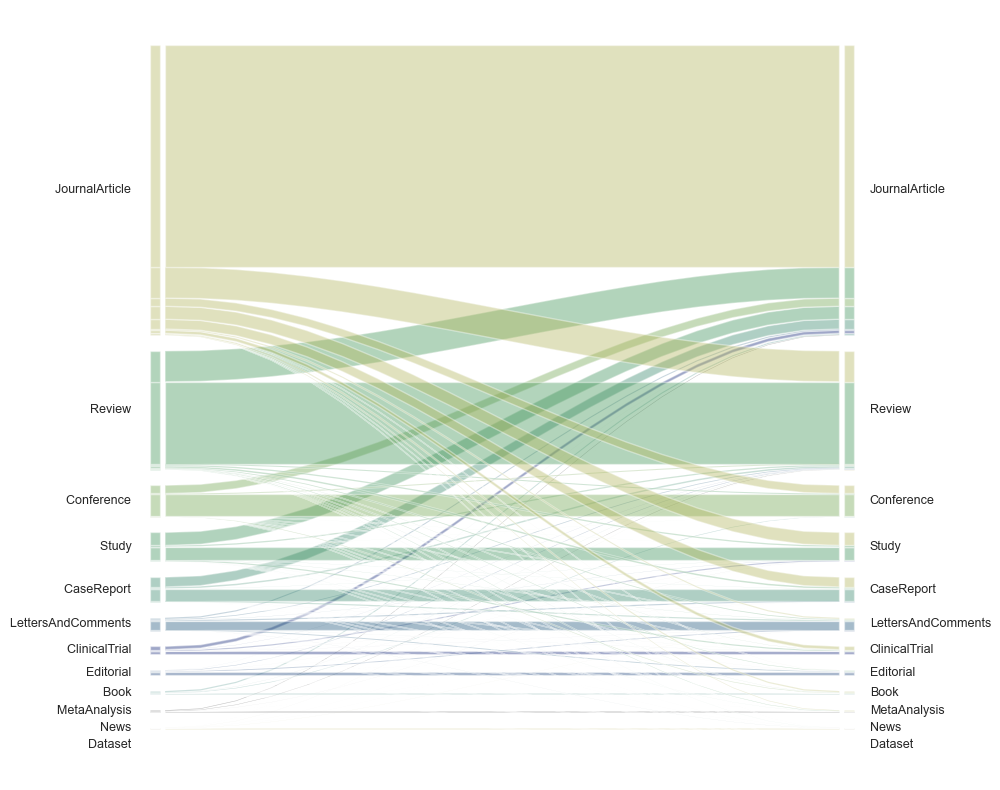

In [25]:
cmap = colormaps['gist_earth']

ax = alluvial.plot(types_dict, alpha=0.4, cmap=cmap, fontname='Arial')
fig = ax.get_figure()
fig.set_size_inches(10,10)
plt.show()
fig.savefig('media/alluvial.png', format='png', bbox_inches='tight', dpi=500)

## Publikationstyp nach Fachgebiet

In [26]:
df_type_fields = client.query(f"""
                               SELECT category, type, COUNT(DISTINCT(corpusid)) AS number_of_publications
                               FROM (
                                  SELECT DISTINCT type, field.category AS category, corpusid
                                  FROM {s2ag_papers}, UNNEST(publicationtypes) as type, 
                                       UNNEST(s2fieldsofstudy) as field 
                               )
                               GROUP BY category, type
                               ORDER BY number_of_publications DESC
                               """).to_dataframe()

In [27]:
df_type_fields_sum = df_type_fields.groupby(['category'])['number_of_publications'].sum().reset_index()\
                                .sort_values(by='number_of_publications', ascending=False)
df_type_fields_sum.rename(columns={'number_of_publications': 'number_of_total_publications'}, inplace=True)
df_type_fields = pd.merge(df_type_fields_sum, df_type_fields, on=['category'])

In [28]:
df_type_fields['proportion'] = (df_type_fields['number_of_publications'])/\
                                        (df_type_fields['number_of_total_publications']) * 100

df_type_fields['proportion'] = df_type_fields['proportion'].apply(lambda x: '{0:.1f}'.format(x))

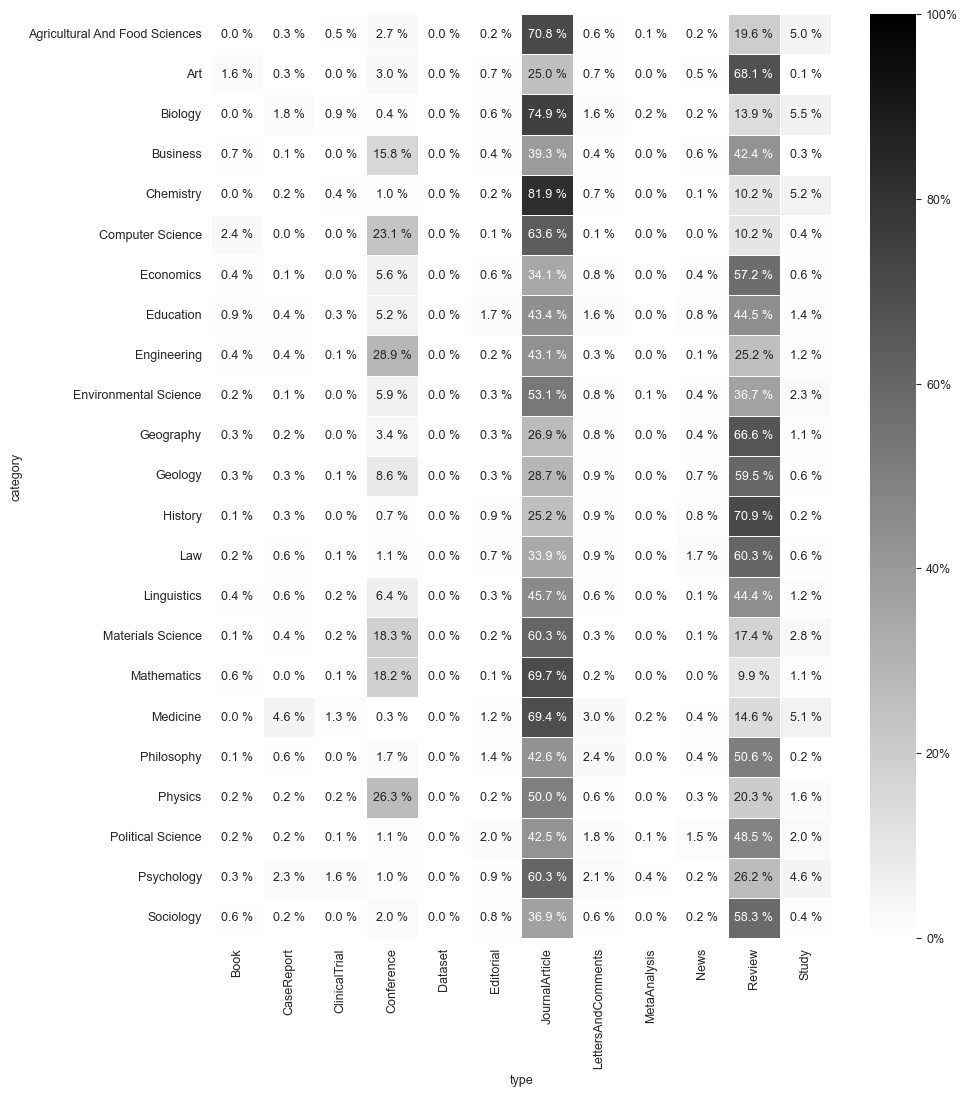

In [29]:
df_type_fields_heatmap = pd.pivot_table(df_type_fields, 
                                        index='category', 
                                        columns='type', 
                                        values='proportion', 
                                        fill_value=float(0))

fig, ax = plt.subplots(figsize=(10, 12))
ax1 = sns.heatmap(df_type_fields_heatmap, 
                  cbar_kws={'format': '%.0f%%'},
                  fmt='',
                  cmap=plt.get_cmap('binary'),
                  annot=True,
                  linewidths=.5,
                  vmin=0,
                  vmax=100,
                  ax=ax)

for t in ax1.texts: t.set_text(t.get_text() + ' %')
plt.show()
fig.savefig('media/category_field.png', format='png', bbox_inches='tight', dpi=500)

## Publikationstyp nach Venue

In [25]:
df_venue = client.query(f"""
                         SELECT venue, COUNT(DISTINCT(corpusid)) AS number_of_total_publications
                         FROM {s2ag_papers}
                         GROUP BY venue
                         ORDER BY number_of_total_publications DESC
                         LIMIT 20
                         """).to_dataframe()

In [26]:
df_venue

,venue,number_of_total_publications
0,,144717004
1,Nature,421802
2,PLoS ONE,274163
3,Science,273596
4,Scientific Reports,220588
5,SSRN Electronic Journal,217401
6,ArXiv,215815
7,Journal of Biological Chemistry,190552
8,The Lancet,178665
9,bioRxiv,164477


In [27]:
df_venue_type = client.query(f"""
                              SELECT venue, COUNT(DISTINCT(corpusid)) AS number_of_publications, type
                              FROM (
                                 SELECT DISTINCT type, venue, corpusid
                                 FROM {s2ag_papers}, UNNEST(publicationtypes) as type 
                              )
                              GROUP BY venue, type
                              ORDER BY number_of_publications DESC
                              """).to_dataframe()

In [28]:
df_venue_type_sum = df_venue_type.groupby(['venue'])['number_of_publications'].sum().reset_index()\
                                .sort_values(by='number_of_publications', ascending=False).head(20)
df_venue_type_sum.rename(columns={'number_of_publications': 'number_of_total_publications'}, inplace=True)

In [29]:
#df_venue_type_merged = pd.merge(df_venue, df_venue_type, on=['venue'])
df_venue_type_merged = pd.merge(df_venue_type_sum, df_venue_type, on=['venue'])

In [30]:
df_venue_type_merged['proportion'] = (df_venue_type_merged['number_of_publications'])/\
                                        (df_venue_type_merged['number_of_total_publications']) * 100

df_venue_type_merged['proportion'] = df_venue_type_merged['proportion'].apply(lambda x: '{0:.2f}'.format(x))

In [31]:
df_venue_type_merged

,venue,number_of_total_publications,number_of_publications,type,proportion
0,,8366837,7332570,Review,87.64
1,,8366837,957882,JournalArticle,11.45
2,,8366837,32098,Editorial,0.38
3,,8366837,26876,Book,0.32
4,,8366837,9221,LettersAndComments,0.11
...,...,...,...,...,...
161,International Journal of Environmental Researc...,75213,376,Editorial,0.50
162,International Journal of Environmental Researc...,75213,374,CaseReport,0.50
163,International Journal of Environmental Researc...,75213,159,MetaAnalysis,0.21
164,International Journal of Environmental Researc...,75213,74,LettersAndComments,0.10


In [32]:
df_venue_type_merged.venue.replace('', 'Venue unknown', inplace=True)
df_venue_type_merged.type.replace('', 'Type unknown', inplace=True)

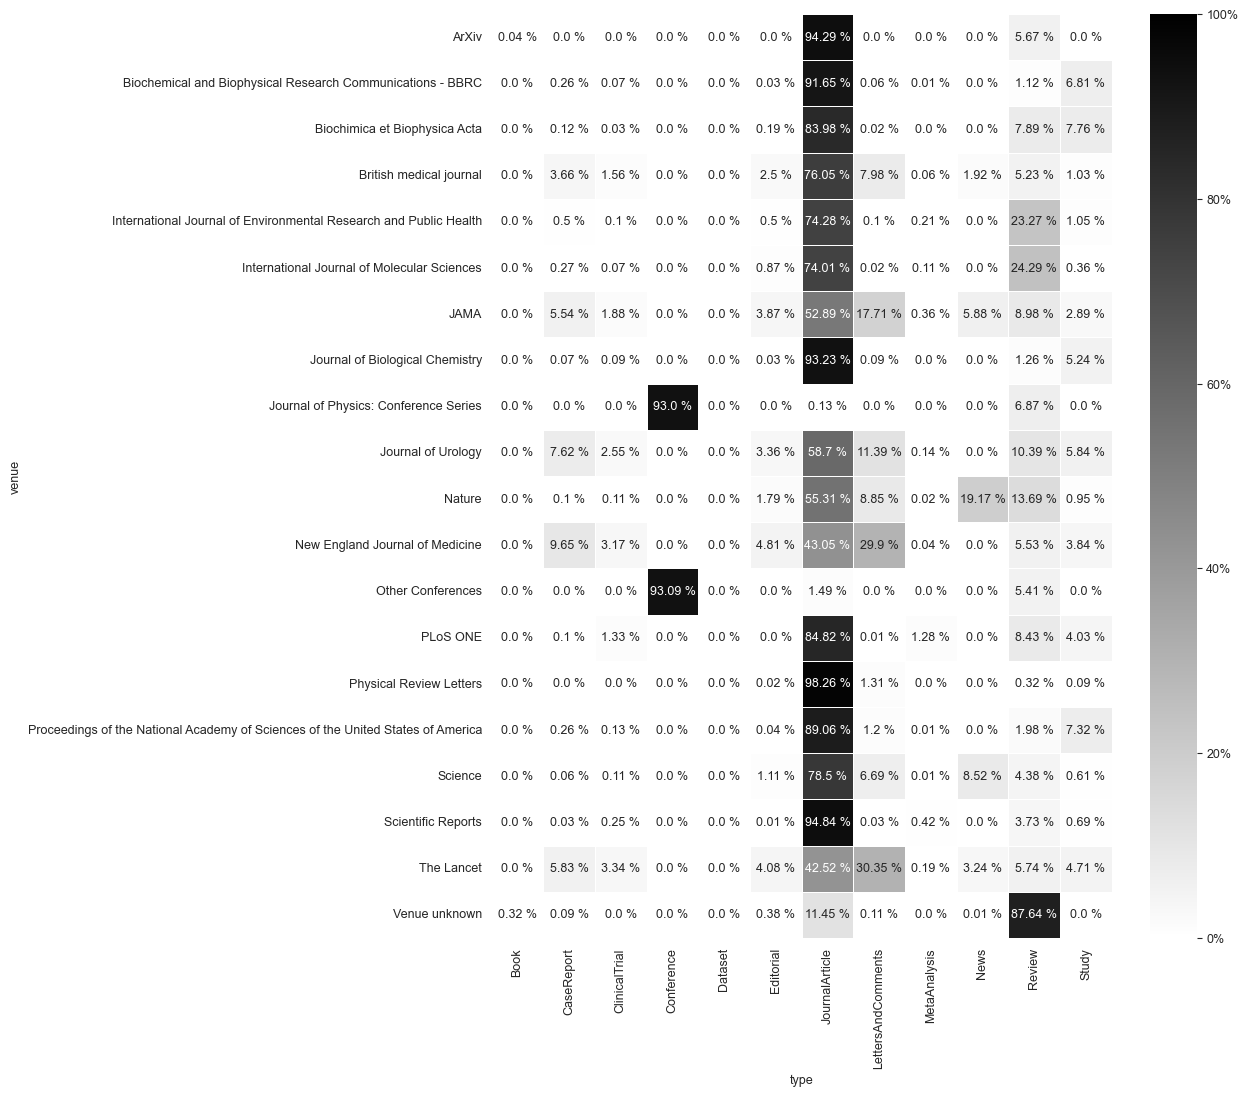

In [33]:
df_heatmap = pd.pivot_table(df_venue_type_merged, 
                            index='venue', 
                            columns='type', 
                            values='proportion', 
                            fill_value=float(0))

fig, ax = plt.subplots(figsize=(10, 12))
ax1 = sns.heatmap(df_heatmap, 
                  cbar_kws={'format': '%.0f%%'},
                  fmt='',
                  cmap=plt.get_cmap('binary'),
                  annot=True,
                  linewidths=.5,
                  vmin=0,
                  vmax=100,
                  ax=ax)

for t in ax1.texts: t.set_text(t.get_text() + ' %')
plt.show()

## Abdeckung nach Fachgebieten

In [32]:
df_fields = client.query(f"""
                          SELECT category, 
                                 COUNT(DISTINCT(corpusid)) AS number_of_publications
                          FROM (
                              SELECT DISTINCT corpusid, field.category AS category
                              FROM {s2ag_papers}, UNNEST(s2fieldsofstudy) as field 
                          )
                          GROUP BY category
                          ORDER BY number_of_publications DESC
                          """).to_dataframe()

In [33]:
df_fields['number_of_total_publications'] = df_fields['number_of_publications'].sum()
df_fields['proportion'] = (df_fields['number_of_publications']/df_fields['number_of_total_publications']) * 100
df_fields['proportion'] = df_fields['proportion'].apply(lambda x: '{0:.2f}'.format(x))

In [34]:
df_fields

,category,number_of_publications,number_of_total_publications,proportion
0,Medicine,48826489,221067398,22.09
1,Biology,23867955,221067398,10.80
2,Chemistry,15700183,221067398,7.10
3,Computer Science,15280707,221067398,6.91
4,Engineering,14278168,221067398,6.46
5,Physics,13207141,221067398,5.97
6,Materials Science,12443360,221067398,5.63
7,Psychology,9938943,221067398,4.50
8,Environmental Science,7329628,221067398,3.32
9,Business,7183939,221067398,3.25


In [37]:
df_fields_venue = client.query(f"""
                                SELECT venue, category, COUNT(DISTINCT(corpusid)) AS number_of_publications
                                FROM (
                                    SELECT DISTINCT corpusid, venue, field.category AS category, 
                                    FROM {s2ag_papers}, UNNEST(s2fieldsofstudy) as field 
                                )
                                GROUP BY venue, category
                                ORDER BY number_of_publications DESC
                                """).to_dataframe()

In [38]:
df_fields_venue

,venue,category,number_of_publications
0,,Medicine,13627013
1,,Engineering,10793780
2,,Chemistry,10004021
3,,Physics,9979422
4,,Materials Science,9509290
...,...,...,...
1272854,Theoretical and Applied Ecology,Geography,1
1272855,The Constitution of Canada,Economics,1
1272856,Linguistic Approaches to Literature,Biology,1
1272857,Writing for the Media,Art,1


In [39]:
df_fields_venue_sum = df_fields_venue.groupby(['venue'])['number_of_publications'].sum().reset_index()\
                                .sort_values(by='number_of_publications', ascending=False).head(20)
df_fields_venue_sum.rename(columns={'number_of_publications': 'number_of_total_publications'}, inplace=True)

In [40]:
df_fields_venue_merged = pd.merge(df_fields_venue_sum, df_fields_venue, on=['venue'])

In [41]:
df_fields_venue_merged['proportion'] = (df_fields_venue_merged['number_of_publications'])/\
                                        (df_fields_venue_merged['number_of_total_publications']) * 100

df_fields_venue_merged['proportion'] = df_fields_venue_merged['proportion'].apply(lambda x: '{0:.1f}'.format(x))

In [42]:
df_fields_venue_merged.venue.replace('', 'Venue unknown', inplace=True)

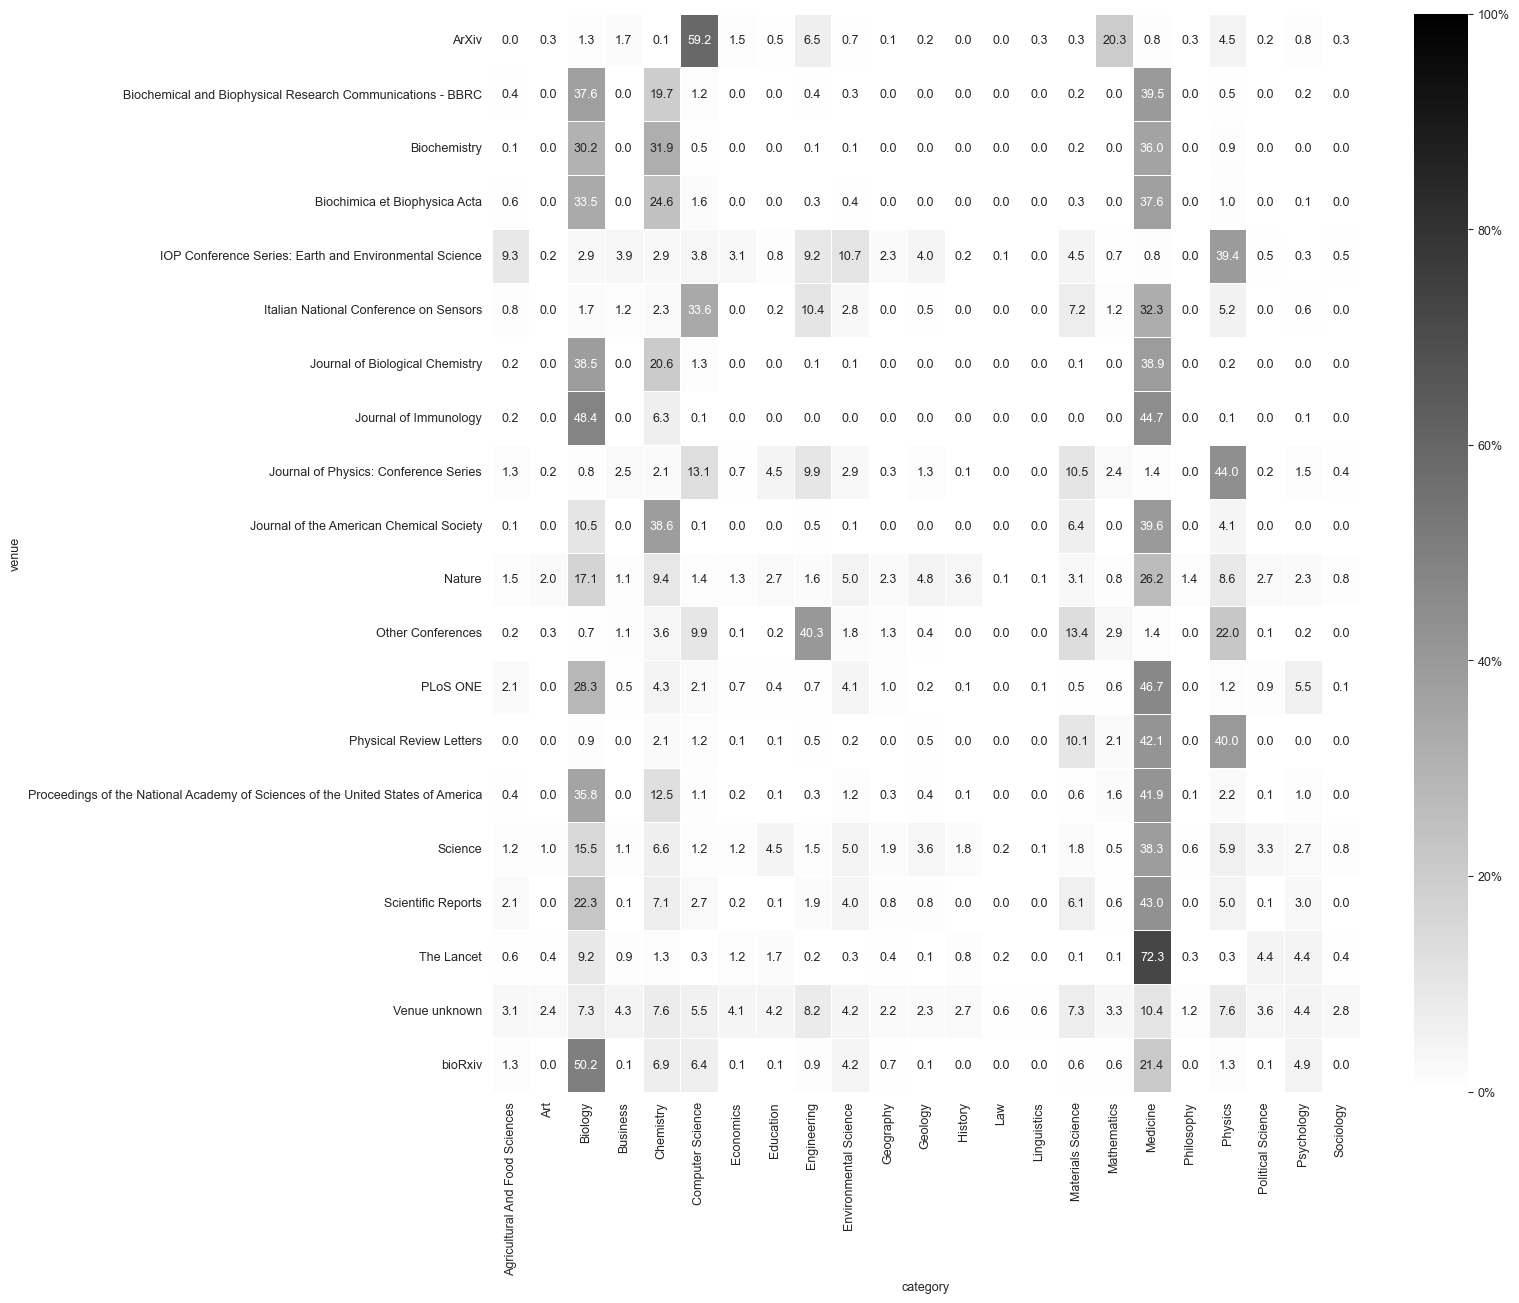

In [43]:
df_heatmap_venue_fields = pd.pivot_table(df_fields_venue_merged, 
                                         index='venue', 
                                         columns='category', 
                                         values='proportion', 
                                         fill_value=float(0))

fig, ax = plt.subplots(figsize=(14, 14))
ax1 = sns.heatmap(df_heatmap_venue_fields, 
                  cbar_kws={'format': '%.0f%%'},
                  fmt='',
                  cmap=plt.get_cmap('binary'),
                  annot=True,
                  linewidths=.5,
                  vmin=0,
                  vmax=100,
                  ax=ax)

#for t in ax1.texts: t.set_text(t.get_text() + ' %')
plt.show()

In [44]:
#SELECT DISTINCT STRING_AGG(fields.category, ",")
#FROM `subugoe-wag-closed.S2AG.papers`, UNNEST(s2fieldsofstudy) AS fields 
#WHERE corpusid = 234301870

## Open Access Anteil Zeitschriften

In [95]:
df_oa = client.query(f"""
                      SELECT isopenaccess, year, COUNT(DISTINCT(corpusid)) AS number_of_publications,
                             COUNT(DISTINCT(doi)) AS number_of_dois
                      FROM (
                          SELECT DISTINCT corpusid, externalids.DOI as doi, 
                                 isopenaccess, EXTRACT (YEAR FROM publicationdate) AS year
                          FROM {s2ag_papers}, UNNEST(publicationtypes) as type 
                          WHERE type = "JournalArticle" AND year >= 2000 AND year < 2023
                          )
                      WHERE year IS NOT NULL
                      GROUP BY isopenaccess, year
                      """).to_dataframe()

In [96]:
df_oa_total_year = df_oa.groupby(['year'])['number_of_publications'].sum().reset_index()
df_oa_total_year.rename(columns={'number_of_publications':'number_of_total_publications'}, inplace=True)
df_oa = pd.merge(df_oa, df_oa_total_year, on='year')

In [106]:
df_oa_doi_prop = df_oa.groupby(['year'])['number_of_dois'].sum().reset_index()
df_oa_doi_prop = pd.merge(df_oa_doi_prop, df_oa[['year', 'number_of_total_publications']], on='year')
df_oa_doi_prop.rename(columns={'number_of_dois':'number_of_total_dois'}, inplace=True)
df_oa_doi_prop['proportion'] = (df_oa_doi_prop['number_of_total_dois']/\
                                df_oa_doi_prop['number_of_total_publications']) * 100
df_oa_doi_prop['proportion'] = df_oa_doi_prop['proportion'].apply(lambda x: '{0:.2f}'.format(x))
df_oa_doi_prop.drop_duplicates()

,year,number_of_total_dois,number_of_total_publications,proportion
0,2000,400571,459956,87.09
2,2001,420320,476024,88.30
4,2002,448442,509576,88.00
6,2003,481735,541531,88.96
8,2004,533827,592558,90.09
10,2005,582223,642227,90.66
12,2006,637494,696887,91.48
14,2007,668742,730167,91.59
16,2008,723457,782214,92.49
18,2009,806578,863106,93.45


In [107]:
df_oa = pd.merge(df_oa, df_oa_doi_prop[['year', 'number_of_total_dois']], on='year')

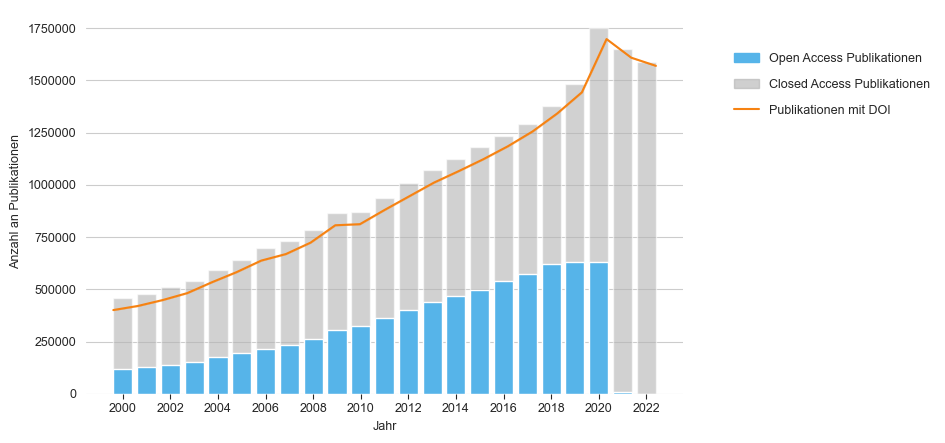

In [114]:
fig, ax = plt.subplots(figsize=(7,4.5))
plt.box(False)

sns.barplot(data=df_oa, 
            x='year', 
            y='number_of_total_publications', 
            alpha=0.6,
            color='#b3b3b3a0',
            saturation=1,
            ax=ax,
            ci=None)

sns.barplot(data=df_oa[df_oa.isopenaccess==True], 
            x='year', 
            y='number_of_publications', 
            alpha=1,
            color='#56B4E9',
            saturation=1,
            ax=ax,
            ci=None)

ax2 = ax.twiny()

sns.lineplot(data=df_oa,
             x='year',
             y='number_of_total_dois',
             color='#f68212',
             ax=ax2)

ax.locator_params(nbins=12, axis='x')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
ax2.grid(False, which='both', axis='x')
ax2.set(xticklabels=[], xlabel=None)
ax2.tick_params(top=False)
ax2.set(xticks=list(range(2000, 2023, 2)))
#ax2.get_legend().remove()

plt.box(False)

ax.set(xlabel='Jahr', ylabel='Anzahl an Publikationen')

oa_patch = mpatches.Patch(color='#56B4E9', label='Open Access Publikationen')
not_oa_patch = mpatches.Patch(color='#b3b3b3a0', label='Closed Access Publikationen')
doi_patch = Line2D([0], [0], color='#f68212', label='Publikationen mit DOI')

lgd = fig.legend(handles=[oa_patch, not_oa_patch, doi_patch], frameon=False,
                 bbox_to_anchor=(1.35, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()

## Open Access nach Venue

In [48]:
df_oa_venue = client.query(f"""
                            SELECT isopenaccess, venue, COUNT(DISTINCT(corpusid)) AS number_of_publications
                            FROM (
                                SELECT DISTINCT corpusid, venue,
                                       isopenaccess, EXTRACT (YEAR FROM publicationdate) AS year
                                FROM {s2ag_papers}, UNNEST(publicationtypes) as type 
                                WHERE type = "JournalArticle" AND year >= 2000
                                )
                            WHERE year IS NOT NULL
                            GROUP BY isopenaccess, venue
                            ORDER BY number_of_publications DESC
                            """).to_dataframe()

In [49]:
df_oa_venue_total = df_oa_venue.groupby(['venue'])['number_of_publications'].sum().reset_index()
df_oa_venue_total.rename(columns={'number_of_publications':'number_of_total_publications'}, inplace=True)
df_oa_venue = pd.merge(df_oa_venue, df_oa_venue_total, on='venue')

In [50]:
df_oa_venue['proportion'] = df_oa_venue['number_of_publications']/df_oa_venue['number_of_total_publications']

In [51]:
df_oa_venue_total.sort_values(by=['number_of_total_publications'], ascending=False).head(20)

,venue,number_of_total_publications
0,,454484
33785,PLoS ONE,263682
7776,ArXiv,204505
38795,Scientific Reports,167559
25617,Journal of Biological Chemistry,83702
34469,Physical Review Letters,68511
23228,International Journal of Molecular Sciences,63176
28977,Journal of the American Chemical Society,61398
35989,Proceedings of the National Academy of Sciences,59598
22951,International Journal of Environmental Researc...,55836


In [52]:
df_oa_venue_hist = pd.merge(df_oa_venue, 
                            df_oa_venue_total.sort_values(by=['number_of_total_publications'], 
                                                          ascending=False).head(20)[['venue']])

In [53]:
df_oa_venue_hist2 = pd.merge(df_oa_venue, 
                             df_oa_venue_total.sort_values(by=['number_of_total_publications'], 
                                                          ascending=False).head(20)[['venue']],
                             how='outer', indicator=True)

In [54]:
df_oa_venue_hist2 = df_oa_venue_hist2.loc[df_oa_venue_hist2._merge == 'left_only'].copy()

In [55]:
df_oa_venue_hist2 = df_oa_venue_hist2.groupby(['isopenaccess'])['number_of_publications']\
                                .sum().reset_index()
df_oa_venue_hist2['number_of_total_publications'] = df_oa_venue_hist2['number_of_publications'].sum()
df_oa_venue_hist2['venue'] = 'Other'
df_oa_venue_hist2['proportion'] = df_oa_venue_hist2['number_of_publications']/\
                                    df_oa_venue_hist2['number_of_total_publications']

In [56]:
df_oa_venue_hist = pd.concat([df_oa_venue_hist, df_oa_venue_hist2], ignore_index=True)

In [57]:
df_oa_venue_hist.venue.replace('', 'Venue unknown', inplace=True)

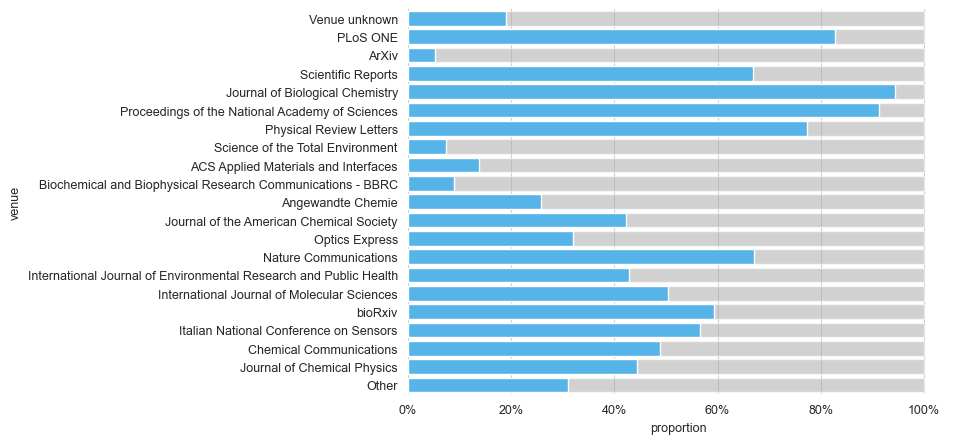

In [58]:
fig, axes = plt.subplots(figsize=(7,5))

plt.box(False)

ax1 = sns.barplot(x=[1] * len(df_oa_venue_hist), 
                  y='venue', 
                  data=df_oa_venue_hist, 
                  label='FALSE', 
                  color='#b3b3b3a0',
                  saturation=1,
                  alpha=0.6
                 )

ax2 = sns.barplot(x='proportion', 
                  y='venue', 
                  data=df_oa_venue_hist[df_oa_venue_hist.isopenaccess == True], 
                  label='TRUE', 
                  color='#56B4E9',
                  saturation=1,
                  alpha=1
                 )

axes.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

## Open Access nach Verlag

In [59]:
df_oa_id = client.query(f"""
                         SELECT isopenaccess, COUNT(DISTINCT(corpusid)) AS number_of_publications
                         FROM (
                             SELECT DISTINCT corpusid, isopenaccess, EXTRACT (YEAR FROM publicationdate) AS year
                             FROM {s2ag_papers}, UNNEST(publicationtypes) as type 
                             WHERE type = "JournalArticle" AND year >= 2008 AND year <= 2021
                             )
                         WHERE year IS NOT NULL
                         GROUP BY isopenaccess
                         ORDER BY number_of_publications DESC
                         """).to_dataframe()

In [60]:
df_oa_doi = client.query(f"""
                          SELECT isopenaccess, COUNT(DISTINCT(doi)) AS number_of_publications
                          FROM (
                              SELECT DISTINCT externalids.DOI as doi, 
                                     isopenaccess, EXTRACT (YEAR FROM publicationdate) AS year
                              FROM {s2ag_papers}, UNNEST(publicationtypes) as type 
                              WHERE type = "JournalArticle" AND year >= 2008 AND year <= 2021
                              )
                          WHERE year IS NOT NULL
                          GROUP BY isopenaccess
                          ORDER BY number_of_publications DESC
                          """).to_dataframe()

In [61]:
df_oa_id['number_of_total_publications'] = df_oa_id['number_of_publications'].sum()
df_oa_id['proportion'] = (df_oa_id['number_of_publications'])/(df_oa_id['number_of_total_publications']) * 100
df_oa_id['proportion'] = df_oa_id['proportion'].apply(lambda x: '{0:.2f}'.format(x))

In [62]:
df_oa_id

,isopenaccess,number_of_publications,number_of_total_publications,proportion
0,False,10562055,16621441,63.54
1,True,6059386,16621441,36.46


In [63]:
df_oa_doi['number_of_total_publications'] = df_oa_doi['number_of_publications'].sum()
df_oa_doi['proportion'] = (df_oa_doi['number_of_publications'])/(df_oa_doi['number_of_total_publications']) * 100
df_oa_doi['proportion'] = df_oa_doi['proportion'].apply(lambda x: '{0:.2f}'.format(x))

In [64]:
df_oa_doi

,isopenaccess,number_of_publications,number_of_total_publications,proportion
0,False,9837570,15896024,61.89
1,True,6058454,15896024,38.11


In [65]:
16621441 - 15896024

725417

In [66]:
upw_snapshot = 'subugoe-collaborative.upw_instant.snapshot'

In [67]:
df_oa_doi_publisher = client.query(f"""
                                   SELECT COUNT(DISTINCT(s2ag.doi)) AS number_of_publications, 
                                          upw.publisher as publisher, s2ag.isopenaccess
                                   FROM (
                                       SELECT DISTINCT externalids.DOI as doi, isopenaccess,
                                              EXTRACT (YEAR FROM publicationdate) AS year
                                       FROM {s2ag_papers}, UNNEST(publicationtypes) as type 
                                       WHERE type = "JournalArticle" AND year >= 2008 AND year <= 2021
                                       ) AS s2ag
                                   INNER JOIN {upw_snapshot} AS upw
                                   ON LOWER(s2ag.doi) = LOWER(upw.doi)
                                   WHERE s2ag.year IS NOT NULL
                                   GROUP BY publisher, s2ag.isopenaccess
                                   ORDER BY number_of_publications DESC
                                   """).to_dataframe()

In [68]:
df_oa_doi_publisher['number_of_publications'].sum()

15570984

In [69]:
15896024 - 12028515

3867509

In [70]:
df_oa_doi_publisher_total = df_oa_doi_publisher.groupby(['publisher'])['number_of_publications']\
                                        .sum().reset_index()
df_oa_doi_publisher_total.rename(columns={'number_of_publications':'number_of_total_publications'}, inplace=True)
df_oa_doi_publisher = pd.merge(df_oa_doi_publisher, df_oa_doi_publisher_total, on='publisher')

In [71]:
df_oa_doi_publisher['proportion'] = df_oa_doi_publisher['number_of_publications']/\
                                        df_oa_doi_publisher['number_of_total_publications']

In [72]:
df_oa_doi_publisher_total.sort_values(by=['number_of_total_publications'], ascending=False).head(20)

,publisher,number_of_total_publications
820,Elsevier BV,2911649
2558,Springer Science and Business Media LLC,1974877
3165,Wiley,1453988
1094,IEEE,999796
2308,SAGE Publications,726854
1158,Informa UK Limited,559905
2043,Ovid Technologies (Wolters Kluwer Health),527757
169,American Chemical Society (ACS),432440
1753,MDPI AG,430700
2046,Oxford University Press (OUP),418685


In [73]:
df_oa_doi_publisher_hist = pd.merge(df_oa_doi_publisher, 
                                    df_oa_doi_publisher_total.sort_values(by=['number_of_total_publications'], 
                                                          ascending=False).head(20)[['publisher']])

In [74]:
df_oa_doi_publisher_hist2 = pd.merge(df_oa_doi_publisher, 
                                     df_oa_doi_publisher_total.sort_values(by=['number_of_total_publications'], 
                                                          ascending=False).head(20)[['publisher']],
                                     how='outer', indicator=True)

In [75]:
df_oa_doi_publisher_hist2 = df_oa_doi_publisher_hist2.loc[df_oa_doi_publisher_hist2._merge == 'left_only'].copy()
df_oa_doi_publisher_hist2 = df_oa_doi_publisher_hist2.groupby(['isopenaccess'])['number_of_publications']\
                                .sum().reset_index()
df_oa_doi_publisher_hist2['number_of_total_publications'] = df_oa_doi_publisher_hist2['number_of_publications']\
                                                                            .sum()
df_oa_doi_publisher_hist2['publisher'] = 'Other'
df_oa_doi_publisher_hist2['proportion'] = df_oa_doi_publisher_hist2['number_of_publications']/\
                                            df_oa_doi_publisher_hist2['number_of_total_publications']

In [76]:
df_oa_doi_publisher_hist = pd.concat([df_oa_doi_publisher_hist, df_oa_doi_publisher_hist2], ignore_index=True)

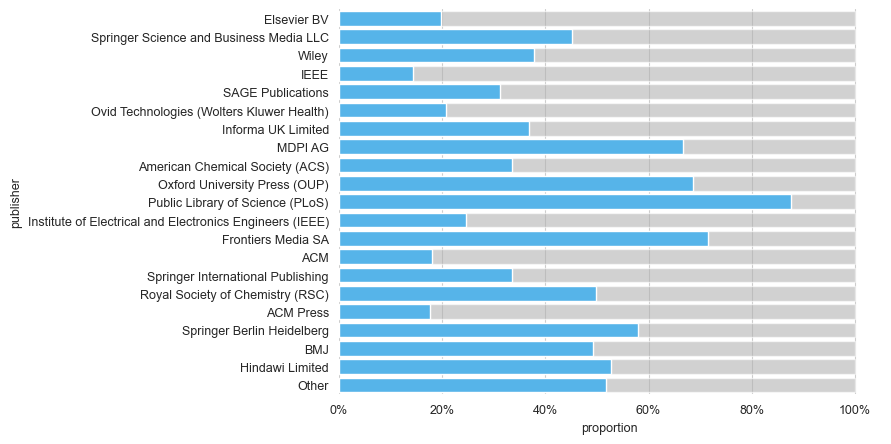

In [77]:
fig, axes = plt.subplots(figsize=(7,5))

plt.box(False)

ax1 = sns.barplot(x=[1] * len(df_oa_doi_publisher_hist), 
                  y='publisher', 
                  data=df_oa_doi_publisher_hist, 
                  label='FALSE', 
                  color='#b3b3b3a0',
                  saturation=1,
                  alpha=0.6
                 )

ax2 = sns.barplot(x='proportion', 
                  y='publisher', 
                  data=df_oa_doi_publisher_hist[df_oa_doi_publisher_hist.isopenaccess == True], 
                  label='TRUE', 
                  color='#56B4E9',
                  saturation=1,
                  alpha=1
                 )

axes.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

## Unpaywall

In [42]:
df_oa_status = client.query(f"""
                             SELECT COUNT(DISTINCT(s2ag.doi)) AS number_of_publications, 
                                    s2ag.year as year,
                                    upw.is_oa as upw_oa_status, s2ag.isopenaccess as s2_oa_status
                             FROM (
                                 SELECT DISTINCT externalids.DOI as doi, isopenaccess,
                                        EXTRACT (YEAR FROM publicationdate) AS year
                                 FROM {s2ag_papers}, UNNEST(publicationtypes) as type 
                                 WHERE type = "JournalArticle" AND year >= 2008 AND year <= 2020
                                 ) AS s2ag
                             INNER JOIN {upw_snapshot} AS upw
                             ON LOWER(s2ag.doi) = LOWER(upw.doi)
                             WHERE s2ag.year IS NOT NULL
                             GROUP BY year, upw_oa_status, s2_oa_status
                             ORDER BY number_of_publications DESC
                             """).to_dataframe()

In [130]:
df_oa_status_upw = df_oa_status.groupby(['upw_oa_status', 'year'])['number_of_publications'].sum().reset_index()
df_oa_status_s2 = df_oa_status.groupby(['s2_oa_status', 'year'])['number_of_publications'].sum().reset_index()

In [131]:
df_oa_status_upw_total = df_oa_status_upw.groupby(['year'])['number_of_publications'].sum().reset_index()
df_oa_status_upw_total.rename(columns={'number_of_publications': 'number_of_total_publications'}, inplace=True)
df_oa_status_upw = pd.merge(df_oa_status_upw, df_oa_status_upw_total, on='year')
df_oa_status_upw['proportion'] = (df_oa_status_upw['number_of_publications']/\
                                  df_oa_status_upw['number_of_total_publications']) * 100
#df_oa_status_upw['proportion'] = df_oa_status_upw['proportion'].apply(lambda x: '{0:.2f}'.format(x))
df_oa_status_upw.drop_duplicates()

,upw_oa_status,year,number_of_publications,number_of_total_publications,proportion
0,False,2008,442411,684431,64.63924
1,True,2008,242020,684431,35.36076
2,False,2009,503653,792889,63.52125
3,True,2009,289236,792889,36.47875
4,False,2010,483858,799742,60.501762
5,True,2010,315884,799742,39.498238
6,False,2011,513998,867556,59.246665
7,True,2011,353558,867556,40.753335
8,False,2012,535369,932422,57.417028
9,True,2012,397053,932422,42.582972


In [132]:
df_oa_status_s2_total = df_oa_status_s2.groupby(['year'])['number_of_publications'].sum().reset_index()
df_oa_status_s2_total.rename(columns={'number_of_publications': 'number_of_total_publications'}, inplace=True)
df_oa_status_s2 = pd.merge(df_oa_status_s2, df_oa_status_s2_total, on='year')
df_oa_status_s2['proportion'] = (df_oa_status_s2['number_of_publications']/\
                                 df_oa_status_s2['number_of_total_publications']) * 100
#df_oa_status_s2['proportion'] = df_oa_status_s2['proportion'].apply(lambda x: '{0:.2f}'.format(x))
df_oa_status_s2.drop_duplicates()

,s2_oa_status,year,number_of_publications,number_of_total_publications,proportion
0,False,2008,431025,684431,62.975669
1,True,2008,253406,684431,37.024331
2,False,2009,490805,792889,61.900846
3,True,2009,302084,792889,38.099154
4,False,2010,475447,799742,59.450048
5,True,2010,324295,799742,40.549952
6,False,2011,506946,867556,58.433807
7,True,2011,360610,867556,41.566193
8,False,2012,533393,932422,57.205107
9,True,2012,399029,932422,42.794893


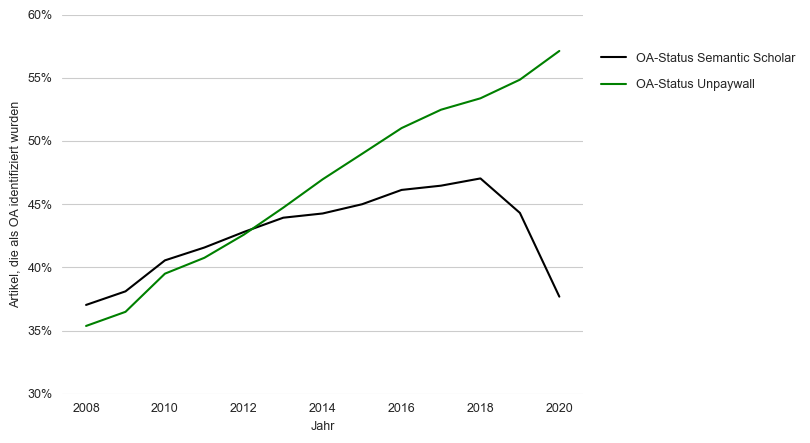

In [150]:
fig, ax = plt.subplots(figsize=(6,4.5))
plt.box(False)

sns.lineplot(data=df_oa_status_s2[df_oa_status_s2.s2_oa_status == True],
             x='year',
             y='proportion',
             color='black',
             ax=ax)

sns.lineplot(data=df_oa_status_upw[df_oa_status_upw.upw_oa_status == True],
             x='year',
             y='proportion',
             color='green',
             ax=ax)

xticks = mtick.FormatStrFormatter('%.0f%%')
ax.yaxis.set_major_formatter(xticks)
ax.grid(False, which='both', axis='x')
ax.set(xlabel='Jahr', ylabel='Artikel, die als OA identifiziert wurden')

s2_patch = Line2D([0], [0], color='black', label='OA-Status Semantic Scholar')
upw_patch = Line2D([0], [0], color='green', label='OA-Status Unpaywall')

lgd = fig.legend(handles=[s2_patch, upw_patch], frameon=False,
                 bbox_to_anchor=(1.35, 0.9), labelspacing=1.1)

plt.ylim(30, 60)

plt.tight_layout()

plt.show()
fig.savefig('media/oa_status_upw_s2.png', format='png', bbox_inches='tight', dpi=500)